## Samarth Motka
## 202311023
## Lab-5

# 1
Find out and show the Magnitude and Phase information of the cameraman image (Fig.1).
Perform log transformation on the magnitude spectrum and show the result. Discuss the reason
of difference between the observations (with log and without log transformation). Observe the
significance of DFT coefficients of the image by reconstructing the image with higher frequency
coefficients and lower frequency coefficients, separately without changing the phase information.


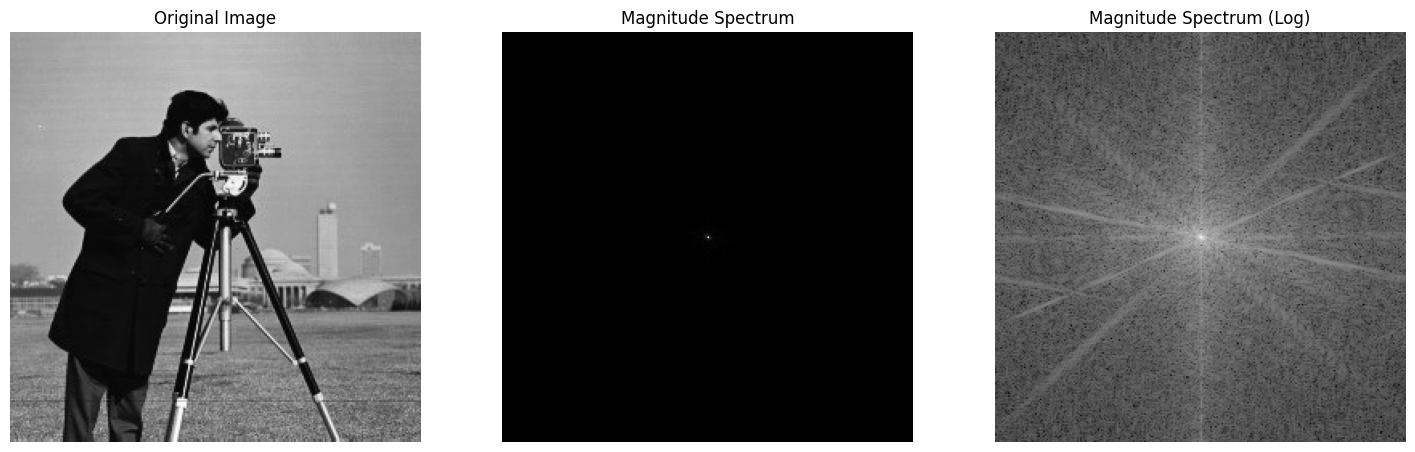

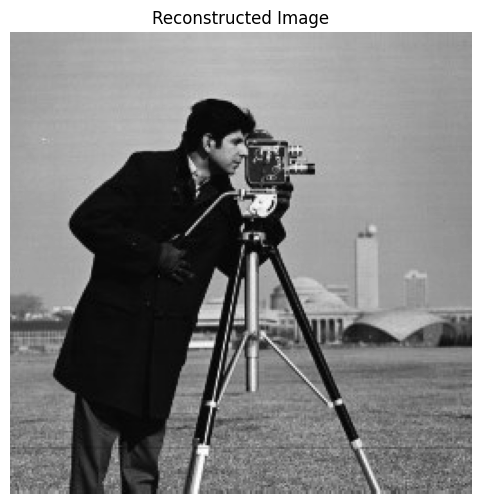

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift

cameraman = plt.imread('/content/cameraman.jpg')

F = fft2(cameraman)
F_shifted = fftshift(F)

magnitude = np.abs(F_shifted)
phase = np.angle(F_shifted)

magnitude_log = np.log(1 + magnitude)

def reconstruct_image(magnitude, phase):
    complex_image = magnitude * np.exp(1j * phase)
    F_ishifted = np.fft.ifftshift(complex_image)
    img_back = np.fft.ifft2(F_ishifted)
    img_back = np.abs(img_back)
    return img_back

reconstructed_image = reconstruct_image(magnitude, phase)

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.imshow(cameraman, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(magnitude, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')

plt.subplot(133)
plt.imshow(magnitude_log, cmap='gray')
plt.title('Magnitude Spectrum (Log)')
plt.axis('off')

plt.show()

plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

np.save('/content/cameraman_magnitude.npy', magnitude)
np.save('/content/cameraman_phase.npy', phase)


# 2
Demonstrate the significance of magnitude and phase information by reconstructing an image

with the magnitude of Fig.2(a) and phase of Fig. 2(b). Repeat the experiment with the mag-
nitude of Fig.2 (b) and phase of Fig.2 (a).

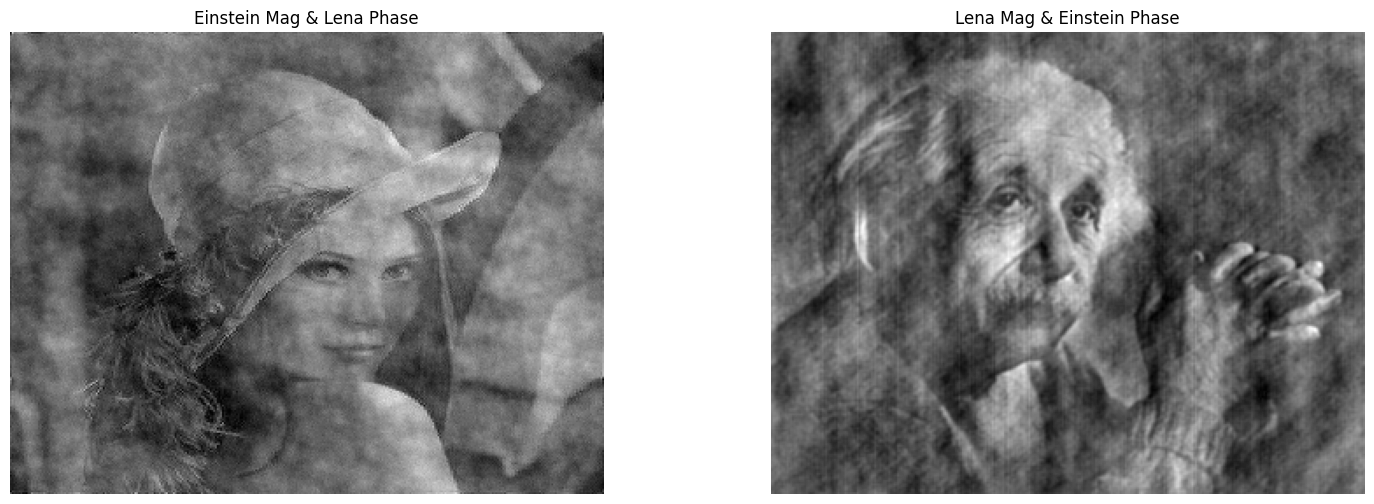

In [ ]:
from skimage.transform import resize

einstein = plt.imread('/content/einstein.jpg')
lena_face = plt.imread('/content/lena_face.jpg')

target_shape = (min(einstein.shape[0], lena_face.shape[0]),
                min(einstein.shape[1], lena_face.shape[1]))

einstein_resized = resize(einstein, target_shape, anti_aliasing=True)
lena_face_resized = resize(lena_face, target_shape, anti_aliasing=True)

F_einstein = fft2(einstein_resized)
F_lena_face = fft2(lena_face_resized)

magnitude_einstein = np.abs(F_einstein)
phase_einstein = np.angle(F_einstein)

magnitude_lena_face = np.abs(F_lena_face)
phase_lena_face = np.angle(F_lena_face)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

einstein_gray = rgb2gray(einstein) if len(einstein.shape) == 3 else einstein
lena_gray = rgb2gray(lena_face) if len(lena_face.shape) == 3 else lena_face

einstein_resized_gray = resize(einstein_gray, target_shape, anti_aliasing=True)
lena_resized_gray = resize(lena_gray, target_shape, anti_aliasing=True)

F_einstein_gray = fft2(einstein_resized_gray)
F_lena_gray = fft2(lena_resized_gray)

magnitude_einstein_gray = np.abs(F_einstein_gray)
phase_einstein_gray = np.angle(F_einstein_gray)

magnitude_lena_gray = np.abs(F_lena_gray)
phase_lena_gray = np.angle(F_lena_gray)

reconstructed_einstein_on_lena_phase = reconstruct_image(magnitude_einstein_gray, phase_lena_gray)
reconstructed_lena_on_einstein_phase = reconstruct_image(magnitude_lena_gray, phase_einstein_gray)

plt.figure(figsize=(18, 6))

plt.subplot(121)
plt.imshow(reconstructed_einstein_on_lena_phase, cmap='gray')
plt.title('Einstein Mag & Lena Phase')
plt.axis('off')

plt.subplot(122)
plt.imshow(reconstructed_lena_on_einstein_phase, cmap='gray')
plt.title('Lena Mag & Einstein Phase')
plt.axis('off')

plt.show()


# 3
Implement low pass and high pass filters in frequency domain for Ideal, Butterworth (order 2),
and Gaussian kernels and apply those on Fig.1. Discuss about the results.

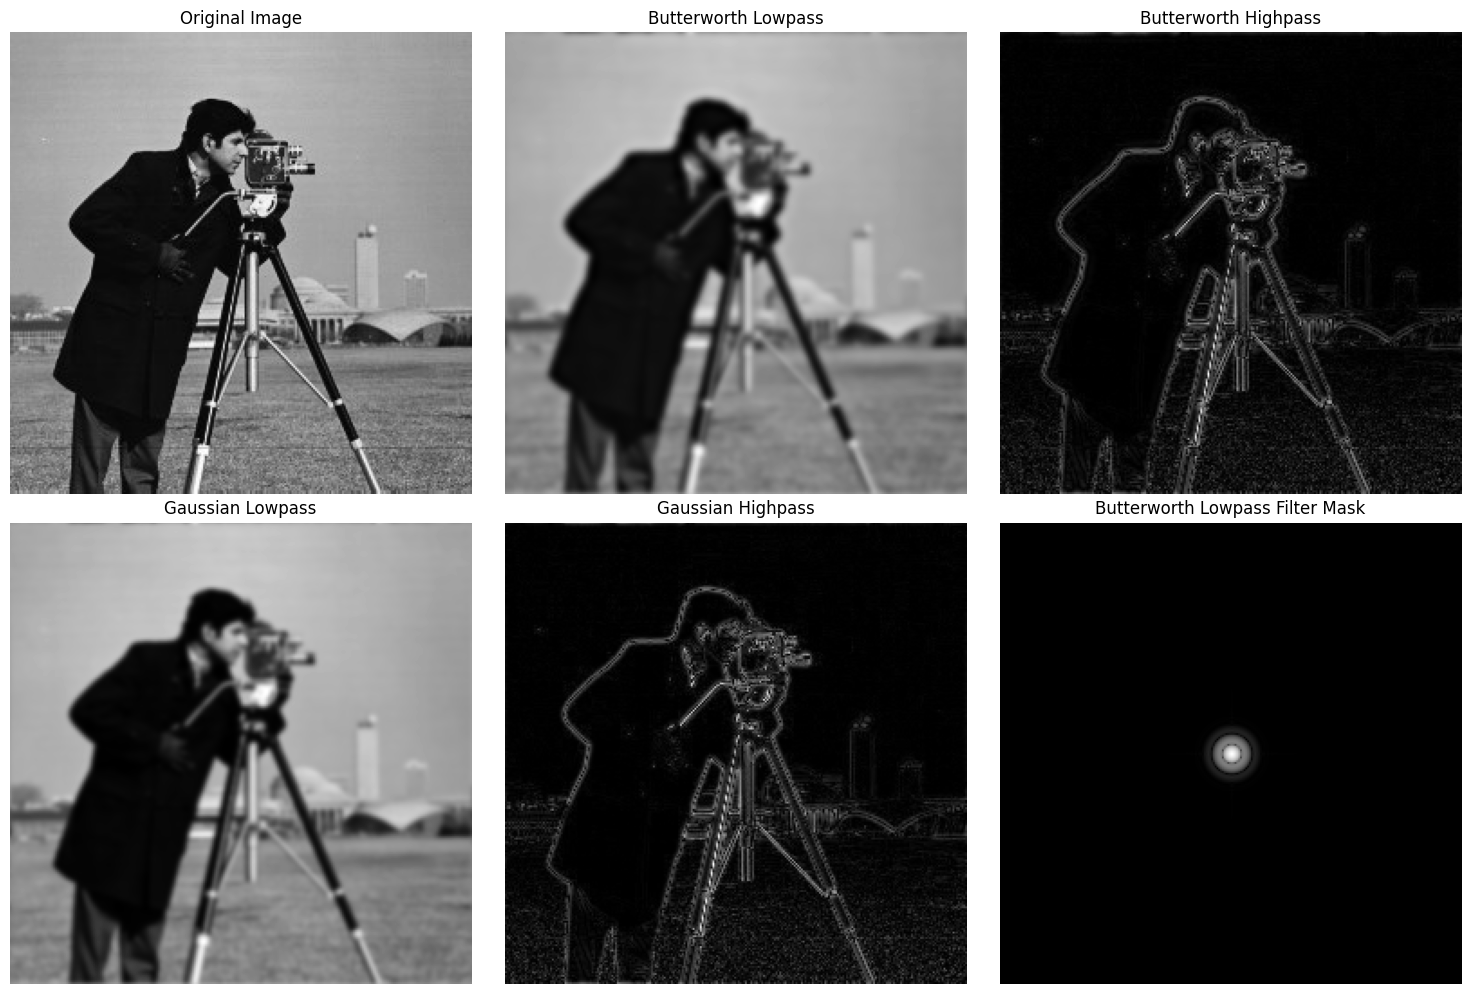

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift

def butterworth_filter(shape, cutoff, order, filter_type):
    P, Q = shape
    U, V = np.meshgrid(range(Q), range(P))
    Duv = np.sqrt((U - Q / 2) ** 2 + (V - P / 2) ** 2)
    if filter_type == 'lowpass':
        H = 1 / (1 + (Duv / cutoff) ** (2 * order))
    elif filter_type == 'highpass':
        H = 1 - 1 / (1 + (Duv / cutoff) ** (2 * order))
    return H

def gaussian_filter(shape, cutoff, filter_type):
    P, Q = shape
    U, V = np.meshgrid(range(Q), range(P))
    Duv = np.sqrt((U - Q / 2) ** 2 + (V - P / 2) ** 2)
    if filter_type == 'lowpass':
        H = np.exp(-(Duv ** 2) / (2 * (cutoff ** 2)))
    elif filter_type == 'highpass':
        H = 1 - np.exp(-(Duv ** 2) / (2 * (cutoff ** 2)))
    return H

def apply_filter(image, filter_func, *args, **kwargs):
    f = fft2(image)
    fshift = fftshift(f)

    filter_mask = filter_func(image.shape, *args, **kwargs)
    fshift_filtered = fshift * filter_mask

    f_ishift = ifftshift(fshift_filtered)
    img_back = ifft2(f_ishift)
    img_filtered = np.abs(img_back)

    return img_filtered, filter_mask

cutoff_frequency = 30
order = 2

butterworth_lowpass_filtered, butterworth_lowpass = apply_filter(cameraman, butterworth_filter, cutoff_frequency, order, 'lowpass')
butterworth_highpass_filtered, butterworth_highpass = apply_filter(cameraman, butterworth_filter, cutoff_frequency, order, 'highpass')

gaussian_lowpass_filtered, gaussian_lowpass = apply_filter(cameraman, gaussian_filter, cutoff_frequency, 'lowpass')
gaussian_highpass_filtered, gaussian_highpass = apply_filter(cameraman, gaussian_filter, cutoff_frequency, 'highpass')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

axes[0].imshow(cameraman, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(butterworth_lowpass_filtered, cmap='gray')
axes[1].set_title('Butterworth Lowpass')
axes[1].axis('off')

axes[2].imshow(butterworth_highpass_filtered, cmap='gray')
axes[2].set_title('Butterworth Highpass')
axes[2].axis('off')

axes[3].imshow(gaussian_lowpass_filtered, cmap='gray')
axes[3].set_title('Gaussian Lowpass')
axes[3].axis('off')

axes[4].imshow(gaussian_highpass_filtered, cmap='gray')
axes[4].set_title('Gaussian Highpass')
axes[4].axis('off')

axes[5].imshow(np.log(1 + np.abs(fftshift(fft2(butterworth_lowpass)))), cmap='gray')
axes[5].set_title('Butterworth Lowpass Filter Mask')
axes[5].axis('off')

plt.tight_layout()
plt.show()


# 4
Consider the image of Fig.1, and implement unsharp masking and highboost filtering in frequency
domain. Compare the results with the implementation of spatial domain operation. Tune the
parameters (cut-off frequency for frequency domain, kernel size for spatial domain, etc.) to
achieve the same results in both domains. Report the results.

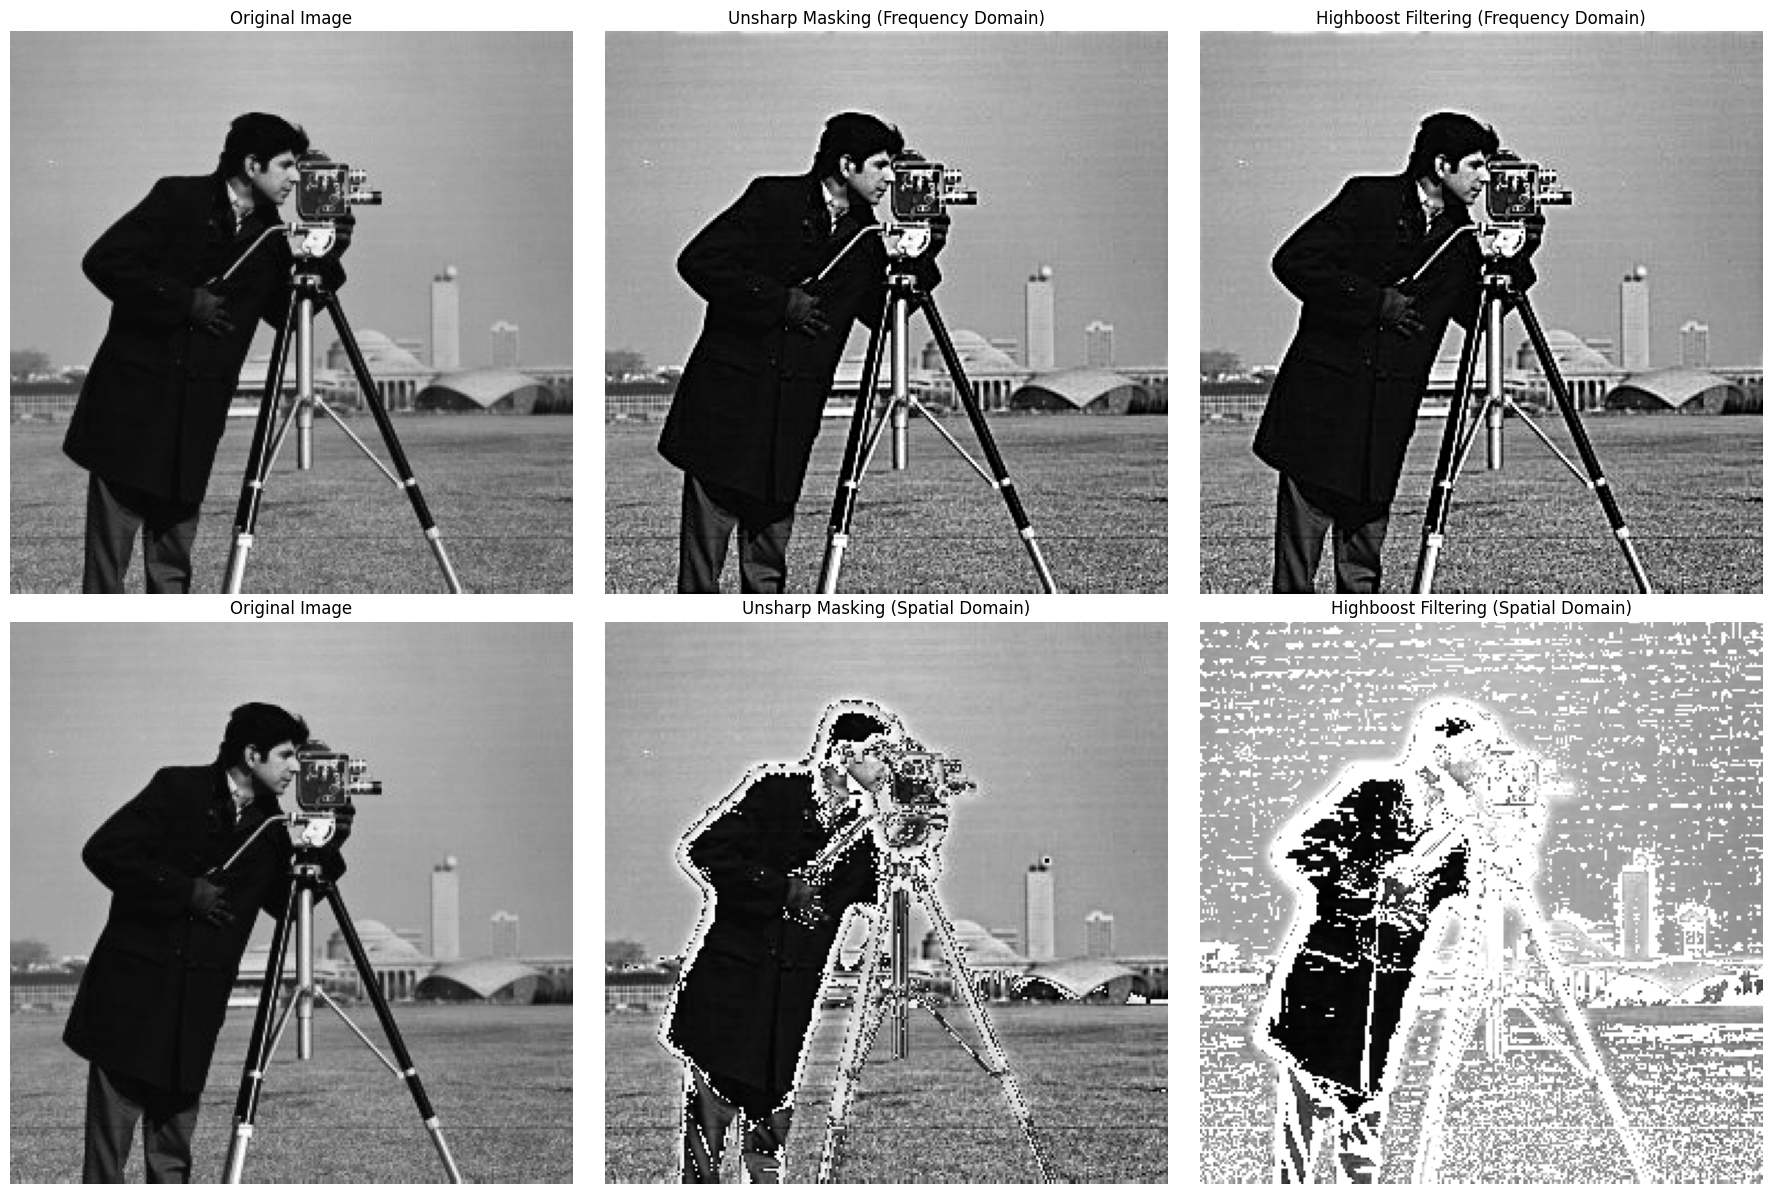

In [ ]:
def unsharp_highboost_filter_frequency_domain(image, cutoff_frequency, k=1.0):
    F_image = fft2(image)
    F_image_shifted = fftshift(F_image)

    gaussian_lowpass = gaussian_filter(image.shape, cutoff_frequency, 'lowpass')

    blurred = ifft2(ifftshift(F_image_shifted * gaussian_lowpass))
    blurred = np.abs(blurred)

    mask = image - blurred

    unsharp_masked = image + mask

    highboost_filtered = image + k * mask

    unsharp_masked = np.clip(unsharp_masked, 0, 255)
    highboost_filtered = np.clip(highboost_filtered, 0, 255)

    return unsharp_masked, highboost_filtered

cutoff_frequency = 30
k = 1.5

unsharp_masked_freq, highboost_filtered_freq = unsharp_highboost_filter_frequency_domain(cameraman, cutoff_frequency, k)

from scipy.ndimage import gaussian_filter as gaussian_blur

def unsharp_highboost_filter_spatial_domain(image, sigma, k=1.0):

    blurred = gaussian_blur(image, sigma=sigma)

    mask = image - blurred

    unsharp_masked = image + mask

    highboost_filtered = image + k * mask

    unsharp_masked = np.clip(unsharp_masked, 0, 255)
    highboost_filtered = np.clip(highboost_filtered, 0, 255)

    return unsharp_masked, highboost_filtered

sigma = 3

unsharp_masked_spatial, highboost_filtered_spatial = unsharp_highboost_filter_spatial_domain(cameraman, sigma, k)

plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.imshow(cameraman, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(unsharp_masked_freq, cmap='gray')
plt.title('Unsharp Masking (Frequency Domain)')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(highboost_filtered_freq, cmap='gray')
plt.title('Highboost Filtering (Frequency Domain)')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(cameraman, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(unsharp_masked_spatial, cmap='gray')
plt.title('Unsharp Masking (Spatial Domain)')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(highboost_filtered_spatial, cmap='gray')
plt.title('Highboost Filtering (Spatial Domain)')
plt.axis('off')

plt.tight_layout()
plt.show()


# 5
Add salt and pepper noise and additive white Gaussian noise (AWGN) separately to the image
given in Figure 3. Salt and pepper noise should corrupt 20% of the pixels, and consider zero
mean and 20 variance for AWGN. Report the results of adding both types of noise. Apply a 5×5
mask of Gaussian low pass filter with a suitable variance on both the noisy images. Furthermore,
apply a median filter of 3 × 3 on both the images. Observe the results and comment on them.

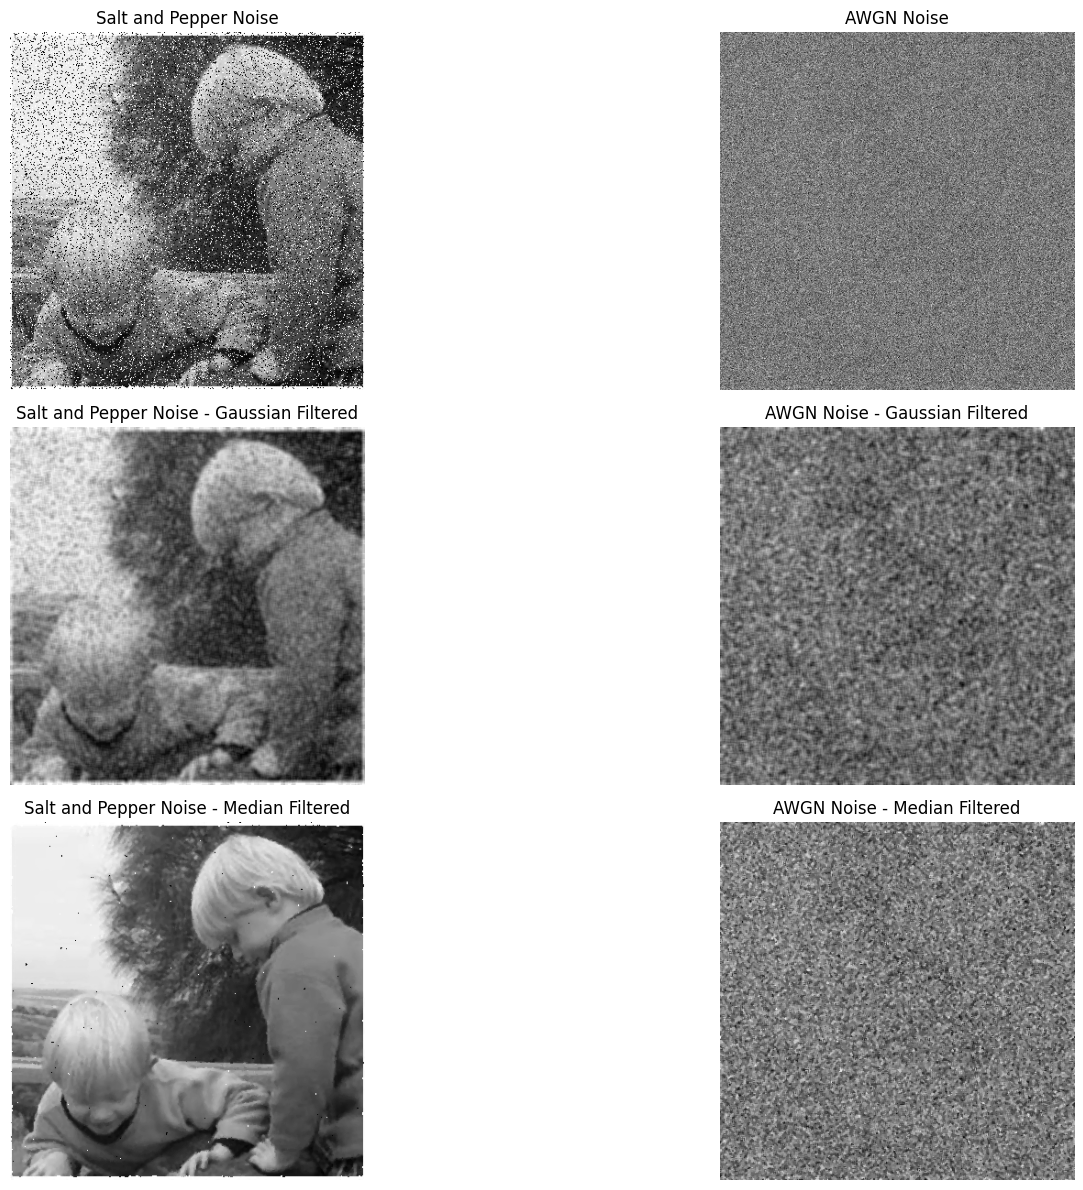

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import median_filter

def add_salt_and_pepper_noise(image, noise_ratio):
    output = np.copy(image)
    num_salt = np.ceil(noise_ratio * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
    output[tuple(coords)] = 1

    num_pepper = np.ceil(noise_ratio * image.size * 0.5)
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
    output[tuple(coords)] = 0

    return output

def add_awgn_noise(image, mean, var):
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, image.shape)
    gauss = gauss.reshape(image.shape)
    noisy = image + gauss
    return noisy

capture_image = plt.imread('/content/Capture.jpg')

capture_image_gray = rgb2gray(capture_image) if len(capture_image.shape) == 3 else capture_image

capture_image_gray = capture_image_gray / 255.0

noise_ratio = 0.20
capture_sp_noise = add_salt_and_pepper_noise(capture_image_gray, noise_ratio)

mean = 0
variance = 20
capture_awgn_noise = add_awgn_noise(capture_image_gray, mean, variance)


capture_sp_gaussian_filtered = cv2.GaussianBlur(capture_sp_noise, (5, 5), variance**0.5)
capture_awgn_gaussian_filtered = cv2.GaussianBlur(capture_awgn_noise, (5, 5), variance**0.5)

capture_sp_median_filtered = median_filter(capture_sp_noise, size=3)
capture_awgn_median_filtered = median_filter(capture_awgn_noise, size=3)

plt.figure(figsize=(18, 12))

plt.subplot(3, 2, 1)
plt.imshow(capture_sp_noise, cmap='gray')
plt.title('Salt and Pepper Noise')
plt.axis('off')

plt.subplot(3, 2, 2)
plt.imshow(capture_awgn_noise, cmap='gray')
plt.title('AWGN Noise')
plt.axis('off')

plt.subplot(3, 2, 3)
plt.imshow(capture_sp_gaussian_filtered, cmap='gray')
plt.title('Salt and Pepper Noise - Gaussian Filtered')
plt.axis('off')

plt.subplot(3, 2, 4)
plt.imshow(capture_awgn_gaussian_filtered, cmap='gray')
plt.title('AWGN Noise - Gaussian Filtered')
plt.axis('off')

plt.subplot(3, 2, 5)
plt.imshow(capture_sp_median_filtered, cmap='gray')
plt.title('Salt and Pepper Noise - Median Filtered')
plt.axis('off')

plt.subplot(3, 2, 6)
plt.imshow(capture_awgn_median_filtered, cmap='gray')
plt.title('AWGN Noise - Median Filtered')
plt.axis('off')

plt.tight_layout()
plt.show()



# 6
Blur the image given in Figure 3 by a second order Butterworth low pass filter with cut-off
frequency 15. Then try to restore the image by inverse filtering without limiting the cut-off
frequency and with limiting cut-off frequency. Use different cut-off frequencies to get the best
result. (Note: You need to add noise to the given image followed by Fourier transformation and
filtering.)

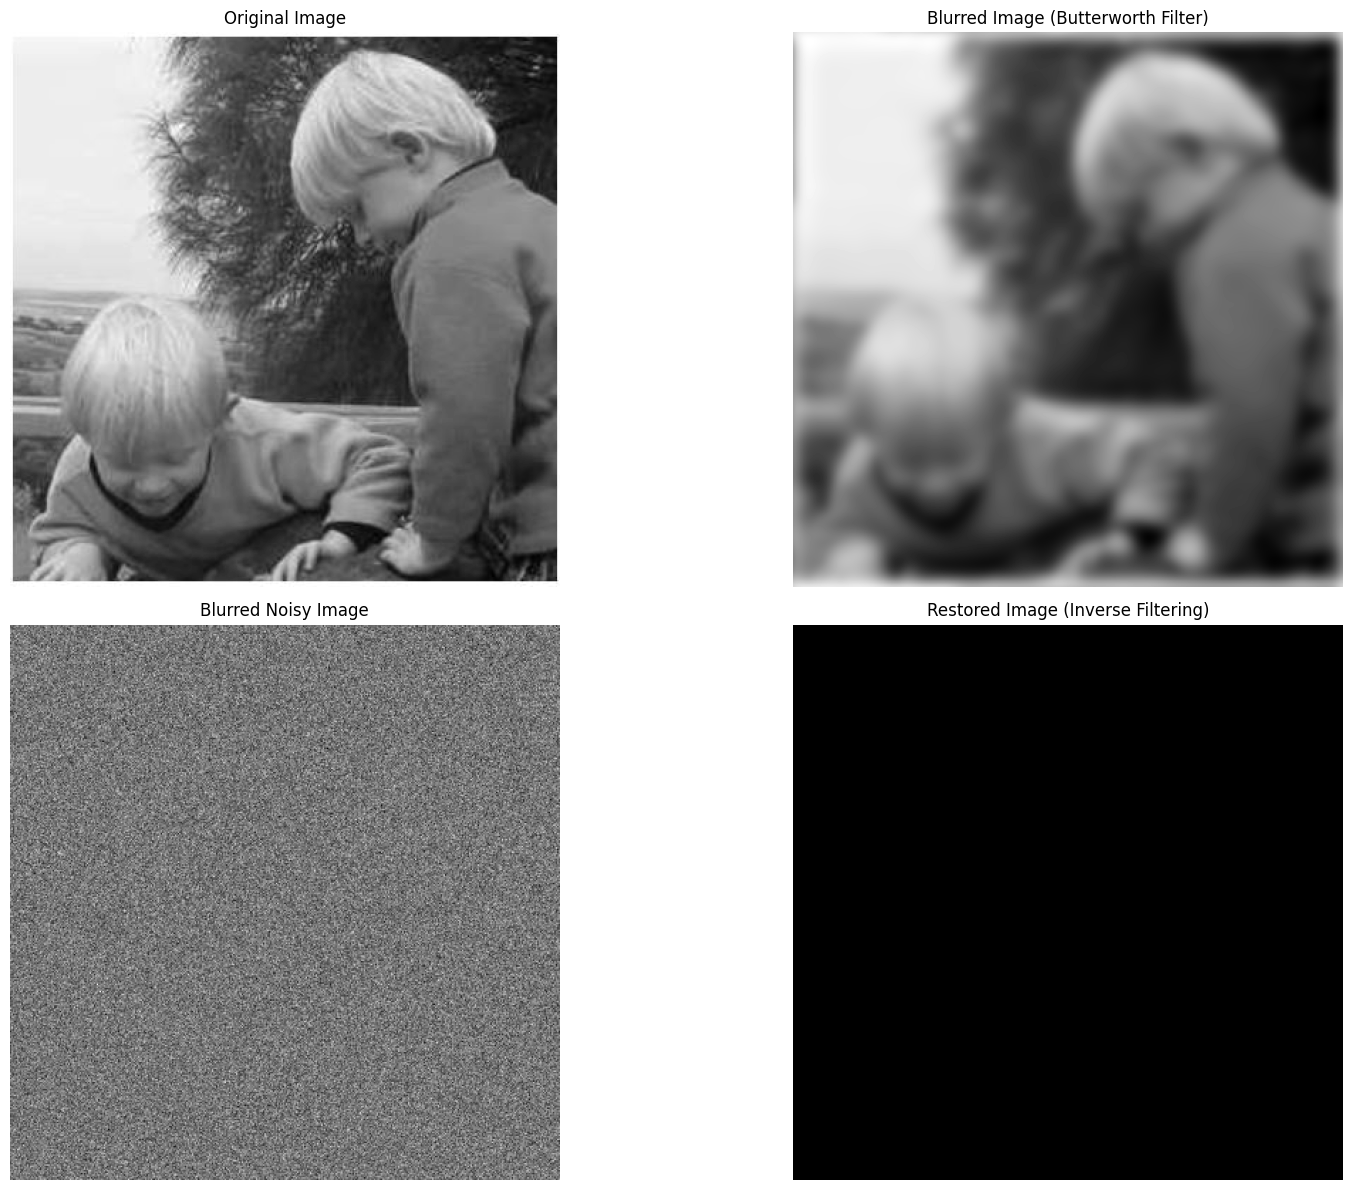

In [ ]:
def butterworth_low_pass(image, cutoff, order=2):
    P, Q = image.shape
    H = np.zeros((P, Q))
    for u in range(P):
        for v in range(Q):
            D_uv = np.sqrt((u - P / 2) ** 2 + (v - Q / 2) ** 2)
            H[u, v] = 1 / (1 + (D_uv / cutoff) ** (2 * order))

    F_image = fftshift(fft2(image))
    G = H * F_image
    filtered_image = np.abs(ifft2(ifftshift(G)))
    return filtered_image, H

cutoff_frequency = 15
order = 2

capture_blurred, H_butterworth = butterworth_low_pass(capture_image_gray, cutoff_frequency, order)

noise_var = 500
capture_blurred_noisy = capture_blurred + np.random.normal(0, np.sqrt(noise_var), capture_blurred.shape)

def inverse_filtering(blurred_noisy_img, filter_H, noise_var):
    blurred_noisy_img_fft = fftshift(fft2(blurred_noisy_img))
    restored_img = np.abs(ifft2(ifftshift(blurred_noisy_img_fft / filter_H)))

    filter_inverse_limited = np.where(filter_H < 1e-1, 0, 1/filter_H)
    restored_img_limited = np.abs(ifft2(ifftshift(blurred_noisy_img_fft * filter_inverse_limited)))

    return restored_img, restored_img_limited

restored_image, restored_image_limited = inverse_filtering(capture_blurred_noisy, H_butterworth, noise_var)

restored_image = np.clip(restored_image, 0, 1)
restored_image_limited = np.clip(restored_image_limited, 0, 1)
plt.figure(figsize=(18, 12))

plt.subplot(2, 2, 1)
plt.imshow(capture_image_gray, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(capture_blurred, cmap='gray')
plt.title('Blurred Image (Butterworth Filter)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(capture_blurred_noisy, cmap='gray')
plt.title('Blurred Noisy Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(restored_image, cmap='gray')
plt.title('Restored Image (Inverse Filtering)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Comment on the results after displaying the images.

# In the inverse filtering without cutoff limitation, noise is significantly amplified, leading to a poor restoration.
# In the limited inverse filtering, where we cap the amplification, the result is typically better as it reduces the noise amplification.
# However, since the original image is not known exactly (it has been corrupted by noise), the restoration cannot be perfect.
# The choice of cutoff frequency for the inverse filtering will affect the balance between noise suppression and detail preservation.



# 7
Consider the blur image created in Problem 6, and restore it using Wiener filtering. Use different
values of K for achieving the best results.

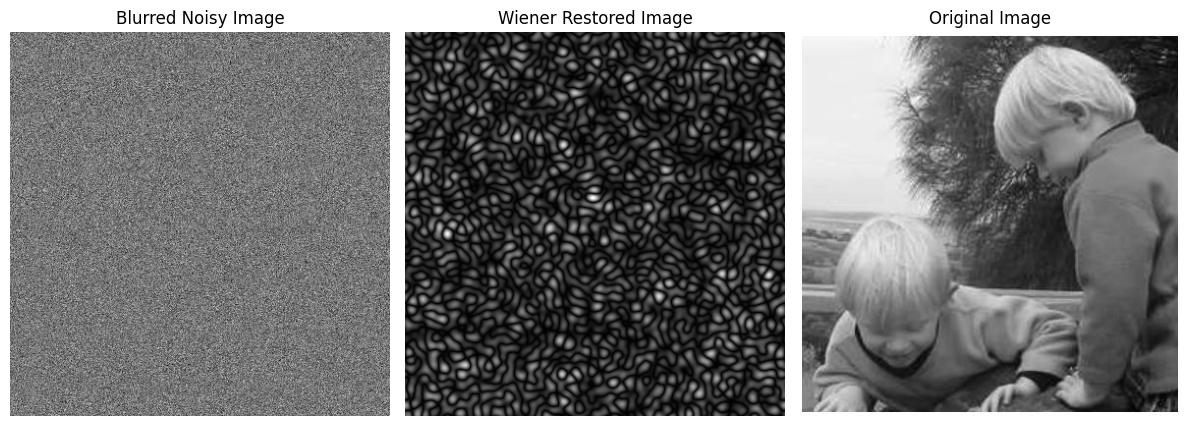

In [ ]:
def wiener_filter(blurred_noisy_img, kernel, K):

    blurred_noisy_fft = fft2(blurred_noisy_img)

    kernel_fft = fft2(kernel, s=blurred_noisy_img.shape)
    kernel_fft_conj = np.conj(kernel_fft)
    denominator = np.abs(kernel_fft)**2 + K
    wiener_filter = kernel_fft_conj / denominator

    restored_fft = wiener_filter * blurred_noisy_fft
    restored_img = np.fft.ifft2(restored_fft)
    restored_img = np.abs(restored_img)

    return restored_img

kernel = H_butterworth


mean_power_spectrum = np.mean(np.abs(fft2(capture_image_gray))**2)
K = 0.001 * mean_power_spectrum

restored_wiener = wiener_filter(capture_blurred_noisy, kernel, K)

restored_wiener = np.clip(restored_wiener / np.max(restored_wiener), 0, 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(capture_blurred_noisy, cmap='gray')
plt.title('Blurred Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(restored_wiener, cmap='gray')
plt.title('Wiener Restored Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.tight_layout()
plt.show()

